# 利用 TF-idf 和 LDA 进行 特征 提取

In [32]:
import gensim
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
import os
from pprint import pprint
import numpy as np
from matplotlib import pyplot as plt
from gensim import corpora, models, similarities

## 准备数据用于训练和测试

In [2]:
news_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = news_dataset.data
print("In the dataset there are", len(documents), "textual documents")
print("And this is the first one:\n", documents[0])


In the dataset there are 18846 textual documents
And this is the first one:
 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




## 预处理

### 分词，去掉停等词

In [3]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]   
print("After the tokenizer, the previous document becomes:\n", tokenize(documents[0]))
processed_docs = [tokenize(doc) for doc in documents]


After the tokenizer, the previous document becomes:
 ['sure', 'bashers', 'pens', 'fans', 'pretty', 'confused', 'lack', 'kind', 'posts', 'recent', 'pens', 'massacre', 'devils', 'actually', 'bit', 'puzzled', 'bit', 'relieved', 'going', 'end', 'non', 'pittsburghers', 'relief', 'bit', 'praise', 'pens', 'man', 'killing', 'devils', 'worse', 'thought', 'jagr', 'showed', 'better', 'regular', 'season', 'stats', 'lot', 'fo', 'fun', 'watch', 'playoffs', 'bowman', 'let', 'jagr', 'lot', 'fun', 'couple', 'games', 'pens', 'going', 'beat', 'pulp', 'jersey', 'disappointed', 'islanders', 'lose', 'final', 'regular', 'season', 'game', 'pens', 'rule']


### 字典化

In [4]:
#每一个单词关联一个唯一的ID
word_count_dict = Dictionary(processed_docs)

### 对字典中的词进行过滤，去除高频低频次

具体使用见

https://blog.csdn.net/u014595019/article/details/52218249

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

1. 去掉出现次数低于no_below的

2. 去掉出现次数高于no_above的。注意这个小数指的是百分数

3. 在1和2的基础上，保留出现频率前keep_n的单词


In [5]:
origin_word_count_dict_len = len(word_count_dict)
word_count_dict.filter_extremes(no_below=5, no_above=0.05)  
print("The origin is",origin_word_count_dict_len,",After filtering, in the corpus there are only", len(word_count_dict), "unique tokens")

The origin is 95506 ,After filtering, in the corpus there are only 21756 unique tokens


### 将文档表示成词袋向量

In [6]:
bag_of_words_corpus = [word_count_dict.doc2bow(pdoc) for pdoc in processed_docs]
print(bag_of_words_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 5), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]


## LDA主题模型

具体详见 https://blog.csdn.net/u014595019/article/details/52218249

### 训练LDA模型

In [7]:
#第一个参数为选用的文档向量，num_topics为主题个数，id2word可选是选用的字典，保存模型，方便下次不用再训练了
model_name = "./output/model.lda"  
if os.path.exists(model_name):
    lda_model = gensim.models.LdaModel.load(model_name)  
    print("loaded from old")
else:
    # preprocess()  
    lda_model = gensim.models.LdaModel(bag_of_words_corpus, num_topics=80, id2word=word_count_dict)#num_topics: the maximum numbers of topic that can provide  
    lda_model.save(model_name)  
    print("loaded from new")


loaded from old


In [8]:
#打印前5个主题
for n in lda_model.print_topics(5):
    print(f"n:{n}")

n:(49, '0.028*"excellent" + 0.014*"speakers" + 0.013*"nf" + 0.012*"channel" + 0.012*"ohio" + 0.011*"dream" + 0.011*"s_" + 0.011*"movie" + 0.010*"stereo" + 0.009*"watts"')
n:(71, '0.028*"evidence" + 0.018*"universe" + 0.016*"science" + 0.016*"atheists" + 0.015*"existence" + 0.012*"scientific" + 0.011*"physical" + 0.009*"objective" + 0.009*"exists" + 0.008*"bush"')
n:(35, '0.021*"rights" + 0.018*"jews" + 0.017*"government" + 0.016*"state" + 0.016*"peace" + 0.014*"muslims" + 0.014*"human" + 0.013*"islamic" + 0.012*"minority" + 0.011*"ethnic"')
n:(7, '0.018*"cable" + 0.015*"apr" + 0.012*"posting" + 0.010*"cpsr" + 0.010*"network" + 0.009*"internet" + 0.008*"easter" + 0.007*"compuserve" + 0.007*"gmt" + 0.007*"phone"')
n:(25, '0.041*"db" + 0.018*"bh" + 0.011*"noise" + 0.010*"gr" + 0.010*"cs" + 0.009*"michael" + 0.009*"band" + 0.009*"tex" + 0.009*"book" + 0.009*"frequency"')


In [9]:
doc_topics = lda_model.get_document_topics(bag_of_words_corpus)  # 所有文档的主题分布
topic = np.array(doc_topics[1])
topic_distribute = np.array(topic[:, 1])
print(f"topic_distribute:{topic_distribute}")
topic_idx = topic_distribute.argsort()[:-10-1:-1]
print('第%d个文档的前%d个主题：' % (0, 10))
print(topic_distribute[topic_idx])


topic_distribute:[0.03169399 0.5080781  0.39812136 0.0324134 ]
第0个文档的前10个主题：
[0.5080781  0.39812136 0.0324134  0.03169399]


### 测试

#### 将该文档分词并表示成词袋向量

In [10]:
test_dataset=fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
test_documents=test_dataset.data[0]
test=word_count_dict.doc2bow(tokenize(test_documents))

#### 用训练好的lda模型测试该文档

In [11]:
result=lda_model.get_document_topics(test)
for topic in result:
        #print_topic(x,y) x是主题的id，y是打印该主题的前y个词，词是按权重排好序的
    print(lda_model.print_topic(topic[0],2))


0.029*"turkey" + 0.022*"ed"
0.051*"car" + 0.018*"average"
0.066*"window" + 0.026*"model"
0.011*"theory" + 0.008*"book"


因为主题的权重没有排序，随便输出几个大的，这里希望输出权重前n名的主题及词分布

In [25]:
def Show2dCorpora(corpus):
    nodes = list(corpus)
    ax0 = [x[0] for x in nodes] # 绘制各个doc代表的点
    ax1 = [x[1] for x in nodes]
    # print(ax0)
    # print(ax1)
    plt.plot(ax0,ax1,'o')
    plt.show()


[(6, 0.033843707), (10, 0.29785144), (21, 0.119427726), (72, 0.50928336)]


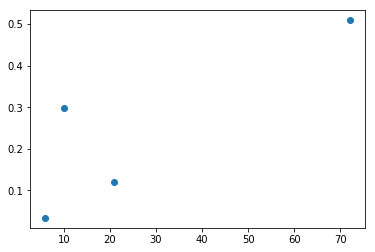

In [29]:
##test
corpus_lda=lda_model[test]
nodes = list(corpus_lda)
pprint(nodes)
lda_model.print_topics(2) 
Show2dCorpora(corpus_lda)

In [30]:
#按照第二个元素从大到小的顺序排列
result_sort=sorted(result,key=lambda tup: -1 * tup[1])
print("下面是该文档对应主题的词分布")
#需要打印出的该文本的前几个主题数
topic_num=5
count=1
for topic in result_sort:
    if count>topic_num:
        break;
    print(lda_model.print_topic(topic[0],2),topic[1])
    count=count+1


下面是该文档对应主题的词分布
0.011*"theory" + 0.008*"book" 0.508868
0.051*"car" + 0.018*"average" 0.29831952
0.066*"window" + 0.026*"model" 0.11897927
0.029*"turkey" + 0.022*"ed" 0.03423957


## 参考

1. [主题提取LDA方法](https://blog.csdn.net/gongdileidechouzhu/article/details/79900702)
2. [LDA利用python进行主题分析提取](https://blog.csdn.net/LEE18254290736/article/details/85142895)